# Hotel EDA
Data from Kaggle: https://www.kaggle.com/datafiniti/hotel-reviews/discussion/33872

In [1]:
#import pandas/np/plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
#bring csv into pandas
file_path = "2_data/hotel.csv"
df = pd.read_csv(file_path)
df.head(1).T

,0
address,Riviera San Nicol 11/a
categories,Hotels
city,Mableton
country,US
latitude,45.4216
longitude,12.3762
name,Hotel Russo Palace
postalCode,30126
province,GA
reviews.date,2013-09-22T00:00:00Z


In [4]:
#rename columns
bad_names = ["reviews.date", "reviews.rating", "reviews.text", "reviews.title"]
good_names = ["date", "rating", "text", "title"]
df.rename(columns = dict(zip(bad_names, good_names)), inplace = True)

In [5]:
df = df[["latitude", "longitude", "name", "address", "postalCode", "categories", "city", "country", "date", "rating", "title", "text"]]

In [6]:
#check out the data
print(df.shape)
print()
print(df.isnull().sum())

(35912, 12)

latitude        86
longitude       86
name             0
address          0
postalCode      55
categories       0
city             0
country          0
date           259
rating         862
title         1621
text            22
dtype: int64


In [7]:
#round ratings
df.dropna(subset = ["rating", "text"], inplace = True)
df["rating"] = df["rating"].astype(float, inplace = True).round(0)
df.rating.value_counts()

5.0     12717
4.0      9835
3.0      5739
1.0      3066
2.0      2986
0.0       337
10.0      155
9.0        73
8.0        73
7.0        26
6.0        21
Name: rating, dtype: int64

In [8]:
#rate the experiences based on numbers
def qualityRev(x):
    if x <= 3:
        return "negative"
    if x > 3:
        return "positive"
    
df["experience"] = df["rating"].apply(qualityRev)
df["experience"].value_counts()

positive    22900
negative    12128
Name: experience, dtype: int64

In [9]:
#fix date, not index bc of duplicates w/0 timestamp
pd.to_datetime(df.date)

0       2013-09-22 00:00:00
1       2015-04-03 00:00:00
2       2014-05-13 00:00:00
3       2013-10-27 00:00:00
4       2015-03-05 00:00:00
5       2015-04-05 00:00:00
6       2014-06-10 00:00:00
7       2015-05-14 00:00:00
8       2015-09-14 00:00:00
9       2015-05-16 00:00:00
10      2015-04-30 00:00:00
11      2015-08-02 00:00:00
12      2016-05-24 00:00:00
13      2016-06-07 00:00:00
14      2015-09-09 00:00:00
15      2014-04-01 00:00:00
16      2015-06-05 00:00:00
17      2015-04-01 00:00:00
18      2015-08-12 00:00:00
19      2014-05-23 00:00:00
20      2015-07-02 00:00:00
21      2015-04-11 00:00:00
22      2015-04-06 00:00:00
23      2015-07-14 00:00:00
24      2015-04-20 00:00:00
25      2014-09-30 00:00:00
26      2015-08-04 00:00:00
27      2015-04-10 00:00:00
28      2015-05-06 00:00:00
29      2016-05-16 00:00:00
                ...        
35882   2015-10-21 00:00:00
35883   2016-07-25 00:00:00
35884   2011-05-04 20:15:22
35885   2008-04-04 02:02:15
35886   2016-06-20 0

## Frequency of noise complaints (in multiple languages)

In [10]:
#multilingual search for sound and noise
soundLang = "|".join \
(("sound", #english
  "larm", #german
  "sonar", #spanish/castillan
  "shengyin", #chinese/pinyin
  "geluid",  #dutch
  "son",  #french
  "som", #portuguese
  "zvuk", "shum")) #russian

noiseLang = "|".join \
(("noise", #english
 "klingen", #german
 "ruido", #spanish/castillan
  "zaosheng", #chinese
 "lawaai", #dutch
 "bruit", #french
 "barulho", #portuguese
  "shum")) #russian

musicLang = "|".join \
(("music", #english
 "musik", #german
 "musica", #spanish/castillan
  "yinyue", #chinese
 "muziek", #dutch
 "musique", #french
 "musica", #portuguese
  "muzyka")) #russian

df["soundR"] = df["text"].str.contains(soundLang)
df["noiseR"] = df["text"].str.contains(noiseLang)
df["soundT"] = df["title"].str.contains(soundLang)
df["noiseT"] = df["title"].str.contains(noiseLang)
df["musicR"] = df["text"].str.contains(musicLang)
df["musicT"] = df["text"].str.contains(musicLang)

df[["soundR", "noiseR", "soundT", "noiseT", "musicR", "musicT"]].apply(pd.Series.value_counts)

,soundR,noiseR,soundT,noiseT,musicR,musicT
False,28678,34267,33370,34121,34911,34911
True,6350,761,786,35,117,117


In [11]:
punctuation = ',?!.\/#@"><[]'

def sonic(x):
    list_of_words = x.split(" ")
    out_data = []
    for word in list_of_words:
        word = word.lower()
        if word.strip(punctuation) in soundLang:
            return "sound"
        if word.strip(punctuation) in noiseLang:
            return "noise"
        if word.strip(punctuation) in musicLang:
            return "music"
        else:
            return "none"
df["sonic"] = df["text"].astype(str).apply(sonic)
df["sonicTitle"] = df["title"].astype(str).apply(sonic)

In [12]:
#sentiments around sound/noise
from textblob import TextBlob

def subjectivityAnalysis(x):
    analysis = TextBlob(x)
    if analysis.sentiment.subjectivity > .5:
        return "subjective"
    if analysis.sentiment.subjectivity == .5:
        return "unknown"
    else:
        return "objective"

def polarityAnalysis(x):
    analysis = TextBlob(x)
    if analysis.sentiment.polarity > 0:
        return "positive"
    if analysis.sentiment.polarity == 0: 
        return "neutral"
    if analysis.sentiment.polarity < 0:
        return "negative"
    

df["subjectivity"] = df["text"].apply(subjectivityAnalysis)
df["polarity"] = df["text"].apply(polarityAnalysis)

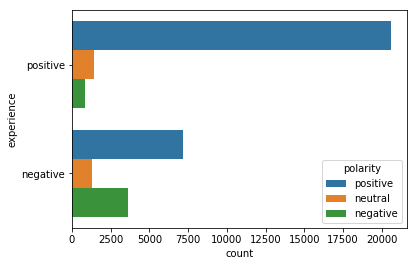

In [13]:
sns.countplot(y = "experience", hue = "polarity", data = df)

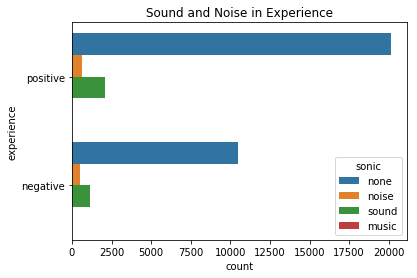

In [14]:
sns.countplot(y = "experience", hue = "sonic", data = df)
plt.title("Sound and Noise in Experience")

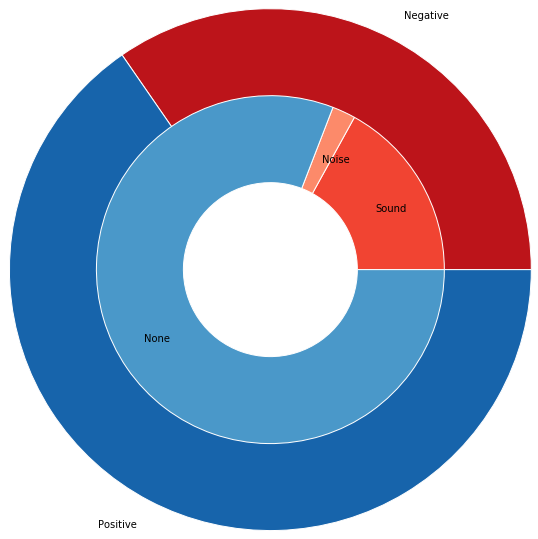

In [15]:
#Donut Plot

group_names=["Negative", "Positive"]
group_size=[12128, 22900]
subgroup_names=["Sound", "Noise", "None"]
subgroup_size=[6434, 821, 30649]
 
a, b = [plt.cm.Blues, plt.cm.Reds]
 
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=3, labels=group_names, colors=[b(0.8), a(0.8)] )
plt.setp( mypie, width=1.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=2.3-0.3, labels=subgroup_names, labeldistance=0.7, 
                   colors=[b(0.6), b(0.4), a(0.6), a(0.4)])
plt.setp( mypie2, width=1.0, edgecolor='white')
plt.margins(0,0)

# show it
plt.show()

In [16]:
#create a data frame of those sound complaints
dfSound = df[(df["soundR"] == True) | (df["noiseR"] == True) | (df["soundT"] == True) | (df["noiseT"] == True)]
dfSound.shape

(7419, 23)

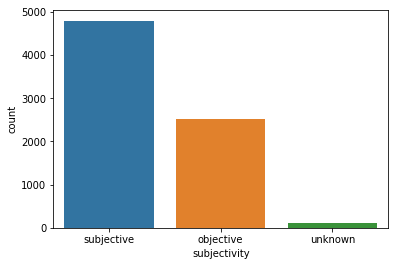

In [17]:
#ratings distribution
import seaborn as sns
sns.countplot(dfSound["subjectivity"])

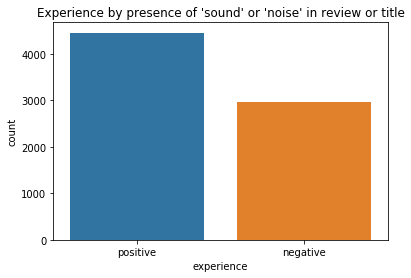

In [16]:
sns.countplot(dfSound.experience)

plt.title("Experience by presence of 'sound' or 'noise' in review or title")

In [18]:
#check subjectivity and polarity in sound
print(dfSound.subjectivity.value_counts())
print(dfSound.polarity.value_counts())

subjective    4794
objective     2515
unknown        110
Name: subjectivity, dtype: int64
positive    5988
negative    1007
neutral      424
Name: polarity, dtype: int64


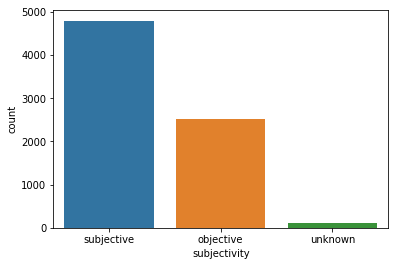

In [19]:
sns.countplot(dfSound.subjectivity)

## General Language Stuff

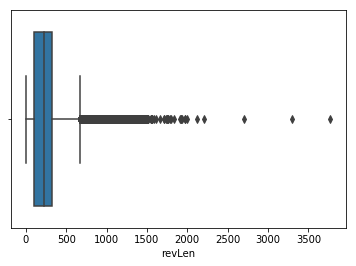

In [25]:
#General Review Length
df["revLen"] =  df["text"].apply(len)
sns.boxplot(df.revLen)

C:\Users\bryce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


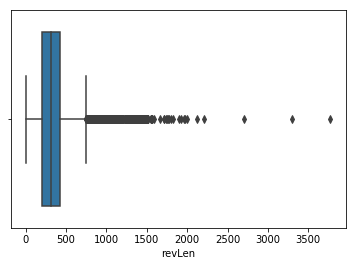

In [28]:
#Review Length of Sound
dfSound["revLen"] = dfSound.text.str.len()
sns.boxplot(dfSound.revLen)

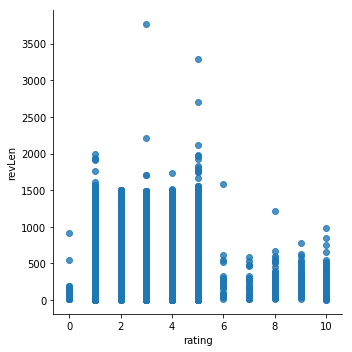

In [34]:
sns.lmplot(x = "rating", y = "revLen", data = df,
           fit_reg = False)

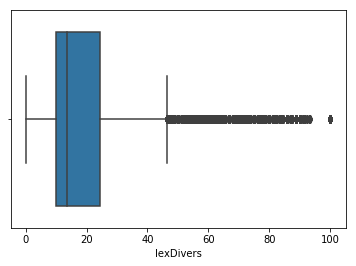

In [38]:
import nltk

def lexical_diversity(x):
    return len(set(x)) / len(x)

def lexical_percentage(x):
    return x * 100

df["lexDivers"] = df.text.apply(lexical_diversity)
df["lexDivers"] =  df.lexDivers.apply(lexical_percentage)

sns.boxplot(df.lexDivers)

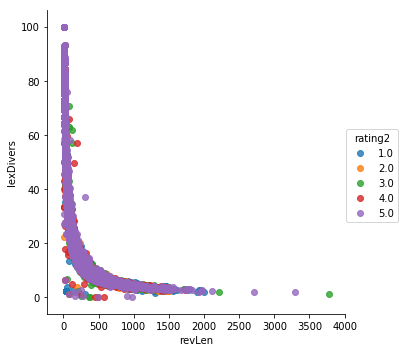

In [43]:
#plot length to diversity to rating

def ratingAdjuster(x):
    if x >= 5:
        return 5
    if x == 0:
        return 1
    else:
        return x

df["rating2"] = df.rating.apply(ratingAdjuster)

sns.lmplot(x = "revLen", y = "lexDivers", data = df,
           fit_reg = False, hue = "rating2")

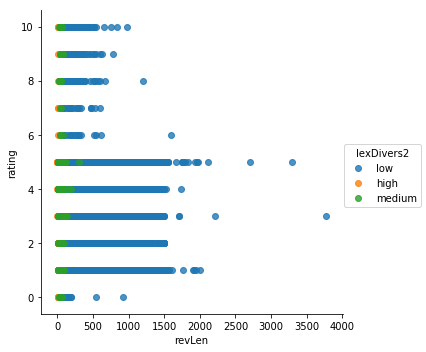

In [40]:
def lexicalDef(x):
    if x < 33:
        return "low"
    if x >= 33 and x < 66:
        return "medium"
    else:
        return "high"

df["lexDivers2"] = df.lexDivers.apply(lexicalDef)

sns.lmplot(x = "revLen", y = "rating", data = df,
           fit_reg = False, hue = "lexDivers2")